# Projet de Reconnaissance de Visages - Groupe 5
## MDSMS1 - Deep Learning

**Membres du groupe:**
- NGOUANA FAUMETE Etienne
- BEINDI MEMANG HOUMBI
- SCHOUAME Jean Pierre
- DEDIM GUELBE APPOLINAIRE

---

## 1. Installation des bibliothèques nécessaires

Exécutez cette cellule pour installer toutes les dépendances nécessaires.

In [29]:
!pip install tensorflow opencv-python numpy pandas matplotlib scikit-learn pillow mtcnn seaborn tqdm

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


## 2. Import des bibliothèques

In [30]:
import subprocess

In [31]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import pickle
import json
from tqdm import tqdm

# TensorFlow et Keras
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# MTCNN pour la détection de visages
from mtcnn import MTCNN

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU disponible: {tf.config.list_physical_devices('GPU')}")

TensorFlow version: 2.19.0
GPU disponible: []


In [9]:
!nvcc --version

/bin/bash: line 1: nvcc: command not found


In [32]:
# Définir le dossier de travail
os.chdir('/home/yvan-ngouana/Downloads/projet deep learning')
  
# Vérifier que ça a fonctionné
print("Dossier de travail actuel:", os.getcwd())

# Lister les fichiers pour confirmer
print("\nFichiers dans ce dossier:")
print(os.listdir('.'))

Dossier de travail actuel: /home/yvan-ngouana/Downloads/projet deep learning

Fichiers dans ce dossier:
['test.csv', 'val.csv', 'Projet_deepLearning.pdf', 'Data', 'Face_Recognition_Project_final.ipynb', 'Data.zip', 'requirements.txt', 'train.csv', 'README.md', 'models', 'processed_data']


## 3. Configuration des chemins et paramètres

In [33]:
# Chemins
DATA_DIR = 'Data'  # Dossier contenant les images brutes
PROCESSED_DIR = 'processed_data'  # Dossier pour les images traitées
MODELS_DIR = 'models'  # Dossier pour sauvegarder les modèles

# Créer les dossiers s'ils n'existent pas
os.makedirs(PROCESSED_DIR, exist_ok=True)
os.makedirs(MODELS_DIR, exist_ok=True)

# Paramètres du modèle
IMG_SIZE = (160, 160)  # Taille des images
BATCH_SIZE = 32
EPOCHS_PHASE1 = 20  # Epochs avec couches gelées
EPOCHS_PHASE2 = 30  # Epochs pour fine-tuning
LEARNING_RATE_PHASE1 = 0.001
LEARNING_RATE_PHASE2 = 0.0001

print("Configuration terminée!")

Configuration terminée!


## 4. Exploration des données

Analysons la structure du dataset et comptons le nombre d'images par étudiant.

In [34]:
# Lister tous les dossiers d'étudiants
student_folders = [f for f in os.listdir(DATA_DIR) if os.path.isdir(os.path.join(DATA_DIR, f))]
student_folders.sort()

print(f"Nombre d'étudiants: {len(student_folders)}\n")
print("Liste des étudiants:")
for i, student in enumerate(student_folders, 1):
    print(f"{i}. {student}")

Nombre d'étudiants: 19

Liste des étudiants:
1. ABONDO
2. BEINDI
3. DEDIM
4. DJOKNONE
5. EKWANE
6. EWOUDI
7. KAMATE
8. KIYINDOU
9. KOUMETIO
10. MAMA
11. MATSING
12. MESSINA
13. MODJARBA
14. NGOUANA
15. OBAMA
16. OTABELA
17. SCHOUAME
18. TCHUIDJANG
19. WAMBE


In [35]:
# Compter le nombre d'images par étudiant
image_counts = {}
total_images = 0

for student in student_folders:
    student_path = os.path.join(DATA_DIR, student)
    
    # Compter les fichiers d'images
    images = [f for f in os.listdir(student_path) 
              if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    
    image_counts[student] = len(images)
    total_images += len(images)

# Créer un DataFrame pour mieux visualiser
df_counts = pd.DataFrame(list(image_counts.items()), columns=['Etudiant', 'Nombre_Images'])
df_counts = df_counts.sort_values('Nombre_Images', ascending=False).reset_index(drop=True)

print(f"\nNombre total d'images: {total_images}")
print(f"Moyenne d'images par étudiant: {total_images / len(student_folders):.1f}")
print(f"\nDistribution:")
print(df_counts)


Nombre total d'images: 369
Moyenne d'images par étudiant: 19.4

Distribution:
      Etudiant  Nombre_Images
0       EKWANE             22
1     SCHOUAME             22
2       EWOUDI             21
3      MATSING             20
4      NGOUANA             20
5        WAMBE             20
6     DJOKNONE             20
7     KIYINDOU             20
8     KOUMETIO             20
9         MAMA             20
10      KAMATE             20
11  TCHUIDJANG             19
12    MODJARBA             19
13       DEDIM             19
14     MESSINA             19
15     OTABELA             18
16      ABONDO             18
17      BEINDI             17
18       OBAMA             15


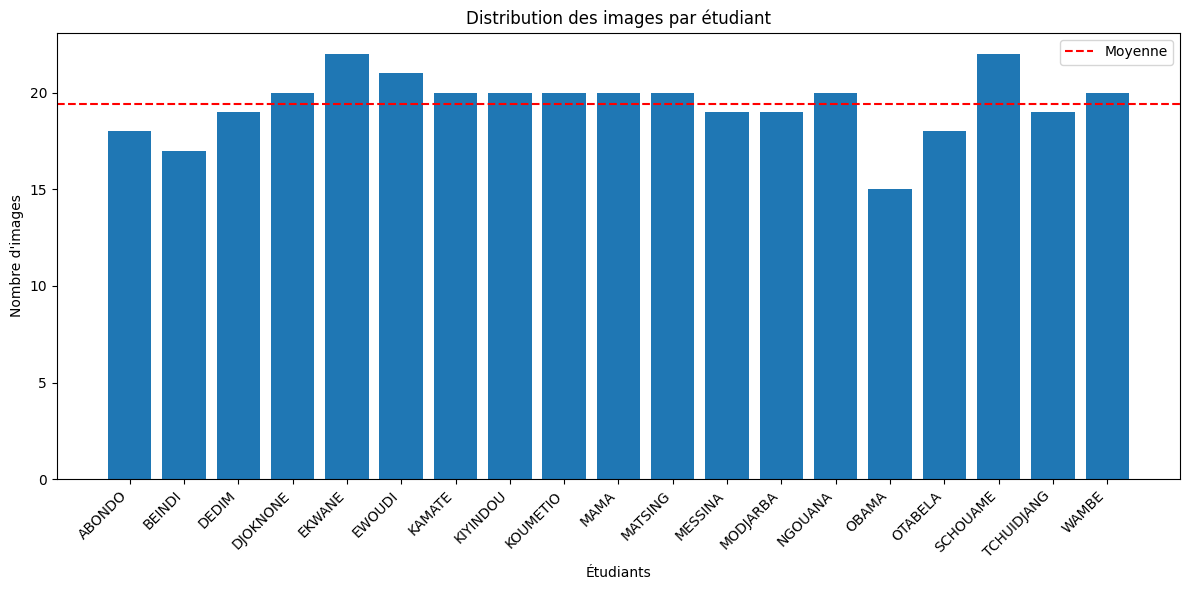

In [36]:
# Visualiser la distribution
plt.figure(figsize=(12, 6))
plt.bar(range(len(image_counts)), list(image_counts.values()))
plt.xticks(range(len(image_counts)), list(image_counts.keys()), rotation=45, ha='right')
plt.xlabel('Étudiants')
plt.ylabel('Nombre d\'images')
plt.title('Distribution des images par étudiant')
plt.axhline(y=np.mean(list(image_counts.values())), color='r', linestyle='--', label='Moyenne')
plt.legend()
plt.tight_layout()
plt.show()

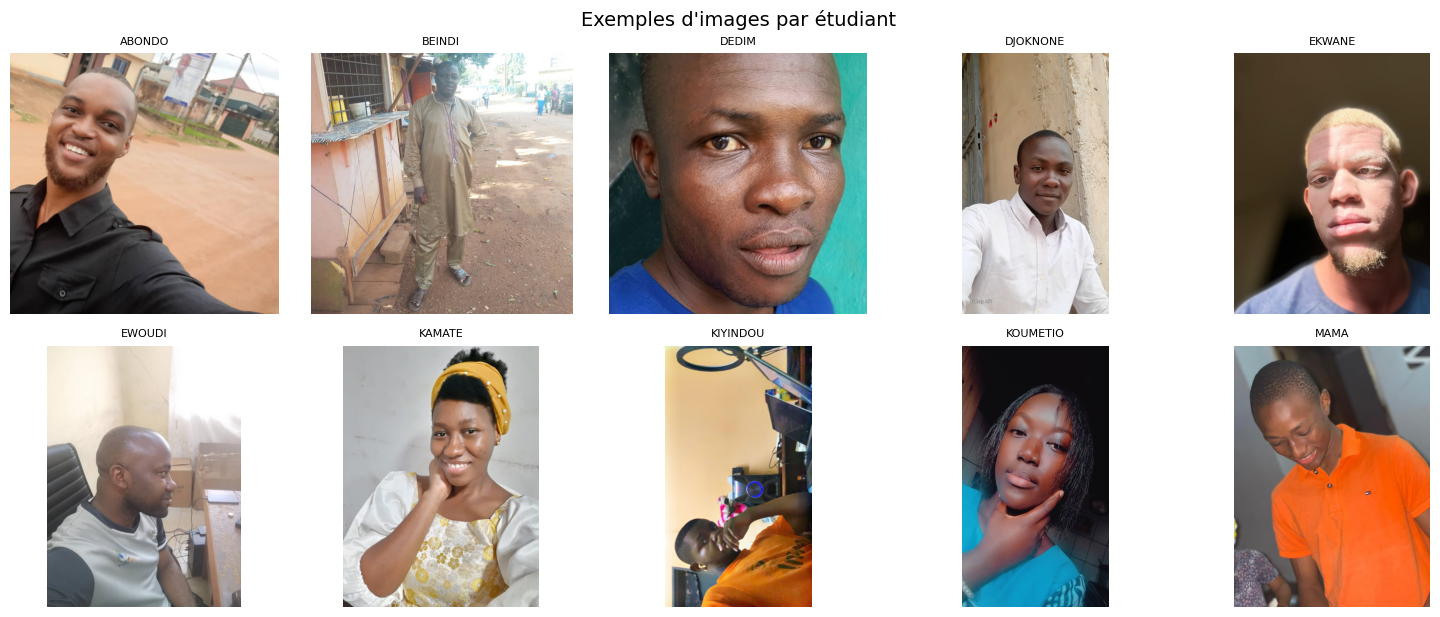

In [11]:
# Afficher quelques exemples d'images
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.ravel()

for i, student in enumerate(student_folders[:10]):
    student_path = os.path.join(DATA_DIR, student)
    images = [f for f in os.listdir(student_path) 
              if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    
    if images:
        img_path = os.path.join(student_path, images[0])
        img = cv2.imread(img_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        axes[i].imshow(img_rgb)
        axes[i].set_title(student, fontsize=8)
        axes[i].axis('off')

plt.tight_layout()
plt.suptitle('Exemples d\'images par étudiant', y=1.02, fontsize=14)
plt.show()

## 5. Pré-traitement des images

Nous allons:
1. Détecter les visages avec MTCNN
2. Recadrer sur le visage
3. Redimensionner à 160x160
4. Sauvegarder les images traitées

In [12]:
# Initialiser le détecteur de visages
detector = MTCNN()

def preprocess_image(image_path, output_path, target_size=(160, 160)):
    """
    Détecte et extrait le visage d'une image
    
    Args:
        image_path: Chemin de l'image source
        output_path: Chemin de sauvegarde
        target_size: Taille cible (width, height)
    
    Returns:
        bool: True si succès, False sinon
    """
    try:
        # Charger l'image
        img = cv2.imread(image_path)
        if img is None:
            return False
        
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Détecter les visages
        faces = detector.detect_faces(img_rgb)
        
        if len(faces) == 0:
            print(f"  Aucun visage détecté: {os.path.basename(image_path)}")
            return False
        
        # Prendre le visage avec la meilleure confiance
        best_face = max(faces, key=lambda x: x['confidence'])
        x, y, w, h = best_face['box']
        
        # S'assurer que les coordonnées sont valides
        x = max(0, x)
        y = max(0, y)
        
        # Extraire le visage avec une petite marge
        margin = int(0.2 * min(w, h))
        x1 = max(0, x - margin)
        y1 = max(0, y - margin)
        x2 = min(img_rgb.shape[1], x + w + margin)
        y2 = min(img_rgb.shape[0], y + h + margin)
        
        face = img_rgb[y1:y2, x1:x2]
        
        # Redimensionner
        face_resized = cv2.resize(face, target_size)
        
        # Sauvegarder
        cv2.imwrite(output_path, cv2.cvtColor(face_resized, cv2.COLOR_RGB2BGR))
        return True
        
    except Exception as e:
        print(f"  Erreur lors du traitement de {os.path.basename(image_path)}: {str(e)}")
        return False

print("Fonction de pré-traitement définie!")

Fonction de pré-traitement définie!


In [13]:
# Traiter toutes les images
processed_count = 0
failed_count = 0

print("Début du pré-traitement des images...\n")

for student in tqdm(student_folders, desc="Étudiants"):
    # Créer le dossier de sortie pour cet étudiant
    student_input_path = os.path.join(DATA_DIR, student)
    student_output_path = os.path.join(PROCESSED_DIR, student)
    os.makedirs(student_output_path, exist_ok=True)
    
    # Lister toutes les images
    images = [f for f in os.listdir(student_input_path) 
              if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    
    print(f"\nTraitement de {student} ({len(images)} images)...")
    
    for img_name in images:
        input_path = os.path.join(student_input_path, img_name)
        output_path = os.path.join(student_output_path, img_name)
        
        if preprocess_image(input_path, output_path, IMG_SIZE):
            processed_count += 1
        else:
            failed_count += 1

print(f"\n" + "="*50)
print(f"Pré-traitement terminé!")
print(f"Images traitées avec succès: {processed_count}")
print(f"Images échouées: {failed_count}")
print(f"Taux de succès: {100 * processed_count / (processed_count + failed_count):.1f}%")
print("="*50)

Début du pré-traitement des images...



Étudiants:   0%|                                         | 0/19 [00:00<?, ?it/s]


Traitement de ABONDO (18 images)...


Étudiants:   5%|█▋                               | 1/19 [00:21<06:24, 21.35s/it]


Traitement de BEINDI (17 images)...
  Aucun visage détecté: WhatsApp Image 2025-10-25 at 15.16.53 (1).jpeg
  Aucun visage détecté: WhatsApp Image 2025-10-25 at 15.16.58 (1).jpeg
  Aucun visage détecté: WhatsApp Image 2025-10-25 at 15.16.59.jpeg
  Aucun visage détecté: WhatsApp Image 2025-10-25 at 15.16.52.jpeg


Étudiants:  11%|███▍                             | 2/19 [00:52<07:42, 27.18s/it]

  Aucun visage détecté: WhatsApp Image 2025-10-25 at 15.16.58.jpeg

Traitement de DEDIM (19 images)...


Étudiants:  16%|█████▏                           | 3/19 [01:15<06:43, 25.22s/it]


Traitement de DJOKNONE (20 images)...


Étudiants:  21%|██████▉                          | 4/19 [01:35<05:49, 23.28s/it]


Traitement de EKWANE (22 images)...
  Aucun visage détecté: WhatsApp Image 2025-10-25 at 15.03.54.jpeg
  Aucun visage détecté: WhatsApp Image 2025-10-25 at 15.04.00.jpeg


Étudiants:  26%|████████▋                        | 5/19 [01:59<05:26, 23.31s/it]


Traitement de EWOUDI (21 images)...


Étudiants:  32%|██████████▍                      | 6/19 [02:21<04:58, 22.99s/it]


Traitement de KAMATE (20 images)...


Étudiants:  37%|████████████▏                    | 7/19 [02:44<04:35, 22.92s/it]


Traitement de KIYINDOU (20 images)...
  Aucun visage détecté: WhatsApp Image 2025-10-25 à 20.00.46_fc3cb6fb.jpg


2025-10-27 07:57:51.324547: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 116764032 exceeds 10% of free system memory.
2025-10-27 07:57:51.464532: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 116764032 exceeds 10% of free system memory.
2025-10-27 07:57:51.568910: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 116764032 exceeds 10% of free system memory.
2025-10-27 07:57:51.626856: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 116764032 exceeds 10% of free system memory.
2025-10-27 07:57:51.693528: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 116764032 exceeds 10% of free system memory.


  Aucun visage détecté: WhatsApp Image 2025-10-25 à 20.00.46_6153cddd.jpg
  Aucun visage détecté: WhatsApp Image 2025-10-25 à 20.00.45_ebdceabe.jpg


Étudiants:  42%|█████████████▉                   | 8/19 [04:19<08:24, 45.88s/it]


Traitement de KOUMETIO (20 images)...


Étudiants:  47%|███████████████▋                 | 9/19 [04:42<06:26, 38.70s/it]


Traitement de MAMA (20 images)...
  Aucun visage détecté: IMG-20251025-WA0019.jpg
  Aucun visage détecté: IMG-20251025-WA0008.jpg
  Aucun visage détecté: IMG-20251025-WA0014.jpg


Étudiants:  53%|████████████████▊               | 10/19 [05:06<05:08, 34.23s/it]


Traitement de MATSING (20 images)...


Étudiants:  58%|██████████████████▌             | 11/19 [05:31<04:11, 31.43s/it]


Traitement de MESSINA (19 images)...


Étudiants:  63%|████████████████████▏           | 12/19 [05:54<03:21, 28.78s/it]


Traitement de MODJARBA (19 images)...


Étudiants:  68%|█████████████████████▉          | 13/19 [06:15<02:39, 26.56s/it]


Traitement de NGOUANA (20 images)...


Étudiants:  74%|███████████████████████▌        | 14/19 [06:39<02:08, 25.61s/it]

  Aucun visage détecté: WhatsApp Image 2025-10-25 à 16.09.58_21e08bb7.jpg

Traitement de OBAMA (15 images)...


Étudiants:  79%|█████████████████████████▎      | 15/19 [06:56<01:32, 23.10s/it]


Traitement de OTABELA (18 images)...
  Aucun visage détecté: WhatsApp Image 2025-10-25 at 15.18.18.jpeg


Étudiants:  84%|██████████████████████████▉     | 16/19 [07:14<01:04, 21.51s/it]


Traitement de SCHOUAME (22 images)...


Étudiants:  89%|████████████████████████████▋   | 17/19 [07:41<00:46, 23.37s/it]


Traitement de TCHUIDJANG (19 images)...
  Aucun visage détecté: WhatsApp Image 2025-10-26 at 08.45.19 (2).jpeg
  Aucun visage détecté: WhatsApp Image 2025-10-26 at 08.45.19 (1).jpeg
  Aucun visage détecté: WhatsApp Image 2025-10-26 at 08.45.21.jpeg
  Aucun visage détecté: WhatsApp Image 2025-10-26 at 08.45.21 (2).jpeg
  Aucun visage détecté: WhatsApp Image 2025-10-26 at 08.45.23.jpeg
  Aucun visage détecté: WhatsApp Image 2025-10-26 at 08.45.20 (1).jpeg


Étudiants:  95%|██████████████████████████████▎ | 18/19 [08:05<00:23, 23.31s/it]

  Aucun visage détecté: WhatsApp Image 2025-10-26 at 08.45.26.jpeg

Traitement de WAMBE (20 images)...
  Aucun visage détecté: IMG-20251025-WA0014.jpg
  Aucun visage détecté: IMG-20251025-WA0009.jpg


Étudiants: 100%|████████████████████████████████| 19/19 [08:27<00:00, 26.73s/it]


Pré-traitement terminé!
Images traitées avec succès: 345
Images échouées: 24
Taux de succès: 93.5%


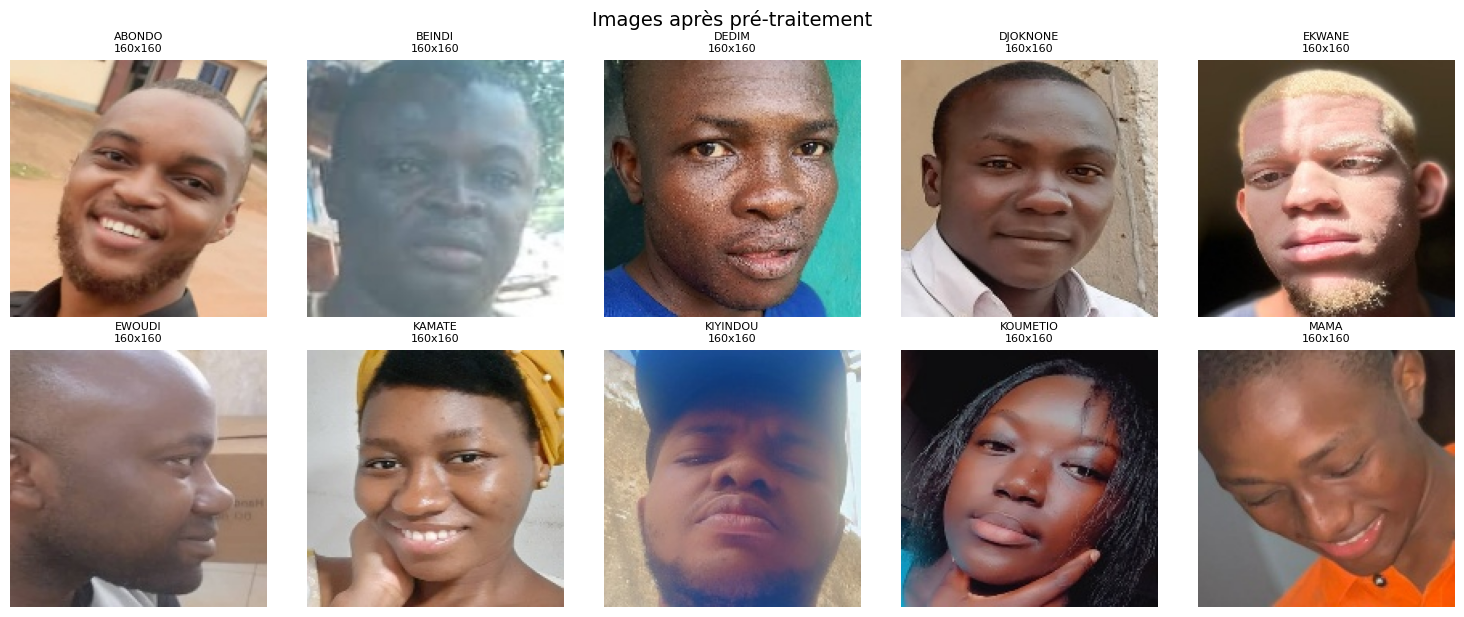

In [15]:
# Vérifier les images traitées
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.ravel()

for i, student in enumerate(student_folders[:10]):
    student_path = os.path.join(PROCESSED_DIR, student)
    if os.path.exists(student_path):
        images = [f for f in os.listdir(student_path) 
                  if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        
        if images:
            img_path = os.path.join(student_path, images[0])
            img = cv2.imread(img_path)
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            axes[i].imshow(img_rgb)
            axes[i].set_title(f"{student}\n{IMG_SIZE[0]}x{IMG_SIZE[1]}", fontsize=8)
            axes[i].axis('off')

plt.tight_layout()
plt.suptitle('Images après pré-traitement', y=1.02, fontsize=14)
plt.show()

## 6. Préparation des données pour l'entraînement

Création des ensembles train, validation et test.

In [16]:
# Créer un DataFrame avec tous les chemins d'images et leurs labels
data = []

for student in student_folders:
    student_path = os.path.join(PROCESSED_DIR, student)
    
    if not os.path.exists(student_path):
        continue
    
    images = [f for f in os.listdir(student_path) 
              if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    
    for img_name in images:
        img_path = os.path.join(student_path, img_name)
        data.append({
            'image_path': img_path,
            'student_name': student
        })

df = pd.DataFrame(data)

print(f"Nombre total d'images dans le dataset: {len(df)}")
print(f"Nombre de classes (étudiants): {df['student_name'].nunique()}")
print(f"\nPremières lignes:")
print(df.head())

Nombre total d'images dans le dataset: 345
Nombre de classes (étudiants): 19

Premières lignes:
                                          image_path student_name
0  processed_data/ABONDO/WhatsApp Image 2025-10-2...       ABONDO
1  processed_data/ABONDO/WhatsApp Image 2025-10-2...       ABONDO
2  processed_data/ABONDO/WhatsApp Image 2025-10-2...       ABONDO
3  processed_data/ABONDO/WhatsApp Image 2025-10-2...       ABONDO
4  processed_data/ABONDO/WhatsApp Image 2025-10-2...       ABONDO


In [17]:
# Encoder les labels
label_encoder = LabelEncoder()
df['student_id'] = label_encoder.fit_transform(df['student_name'])

print(f"Nombre de classes: {len(label_encoder.classes_)}")
print(f"\nMapping des labels:")
for i, name in enumerate(label_encoder.classes_):
    print(f"{i}: {name}")

Nombre de classes: 19

Mapping des labels:
0: ABONDO
1: BEINDI
2: DEDIM
3: DJOKNONE
4: EKWANE
5: EWOUDI
6: KAMATE
7: KIYINDOU
8: KOUMETIO
9: MAMA
10: MATSING
11: MESSINA
12: MODJARBA
13: NGOUANA
14: OBAMA
15: OTABELA
16: SCHOUAME
17: TCHUIDJANG
18: WAMBE


In [18]:
# Séparer en train (70%), validation (15%), test (15%)
# D'abord séparer train et temp (train 70%, temp 30%)
train_df, temp_df = train_test_split(
    df, 
    test_size=0.3, 
    stratify=df['student_id'], 
    random_state=42
)

# Ensuite séparer temp en validation et test (50-50)
val_df, test_df = train_test_split(
    temp_df, 
    test_size=0.5, 
    stratify=temp_df['student_id'], 
    random_state=42
)

print(f"Ensemble d'entraînement: {len(train_df)} images ({100 * len(train_df) / len(df):.1f}%)")
print(f"Ensemble de validation: {len(val_df)} images ({100 * len(val_df) / len(df):.1f}%)")
print(f"Ensemble de test: {len(test_df)} images ({100 * len(test_df) / len(df):.1f}%)")
print(f"\nTotal: {len(train_df) + len(val_df) + len(test_df)} images")

Ensemble d'entraînement: 241 images (69.9%)
Ensemble de validation: 52 images (15.1%)
Ensemble de test: 52 images (15.1%)

Total: 345 images


In [19]:
# Sauvegarder les DataFrames
train_df.to_csv('train.csv', index=False)
val_df.to_csv('val.csv', index=False)
test_df.to_csv('test.csv', index=False)

# Sauvegarder le label encoder
with open(os.path.join(MODELS_DIR, 'label_encoder.pkl'), 'wb') as f:
    pickle.dump(label_encoder, f)

print("Fichiers CSV et label encoder sauvegardés!")

Fichiers CSV et label encoder sauvegardés!


## 7. Création des générateurs de données

Avec augmentation des données pour améliorer la généralisation.

In [20]:
# Générateur pour l'entraînement avec augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

# Générateur pour validation et test (seulement normalisation)
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Créer les générateurs
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='image_path',
    y_col='student_name',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_test_datagen.flow_from_dataframe(
    val_df,
    x_col='image_path',
    y_col='student_name',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator = val_test_datagen.flow_from_dataframe(
    test_df,
    x_col='image_path',
    y_col='student_name',
    target_size=IMG_SIZE,
    batch_size=1,
    class_mode='categorical',
    shuffle=False
)

num_classes = len(train_generator.class_indices)
print(f"\nNombre de classes: {num_classes}")
print(f"Indices des classes: {train_generator.class_indices}")

Found 241 validated image filenames belonging to 19 classes.
Found 52 validated image filenames belonging to 19 classes.
Found 52 validated image filenames belonging to 19 classes.

Nombre de classes: 19
Indices des classes: {'ABONDO': 0, 'BEINDI': 1, 'DEDIM': 2, 'DJOKNONE': 3, 'EKWANE': 4, 'EWOUDI': 5, 'KAMATE': 6, 'KIYINDOU': 7, 'KOUMETIO': 8, 'MAMA': 9, 'MATSING': 10, 'MESSINA': 11, 'MODJARBA': 12, 'NGOUANA': 13, 'OBAMA': 14, 'OTABELA': 15, 'SCHOUAME': 16, 'TCHUIDJANG': 17, 'WAMBE': 18}


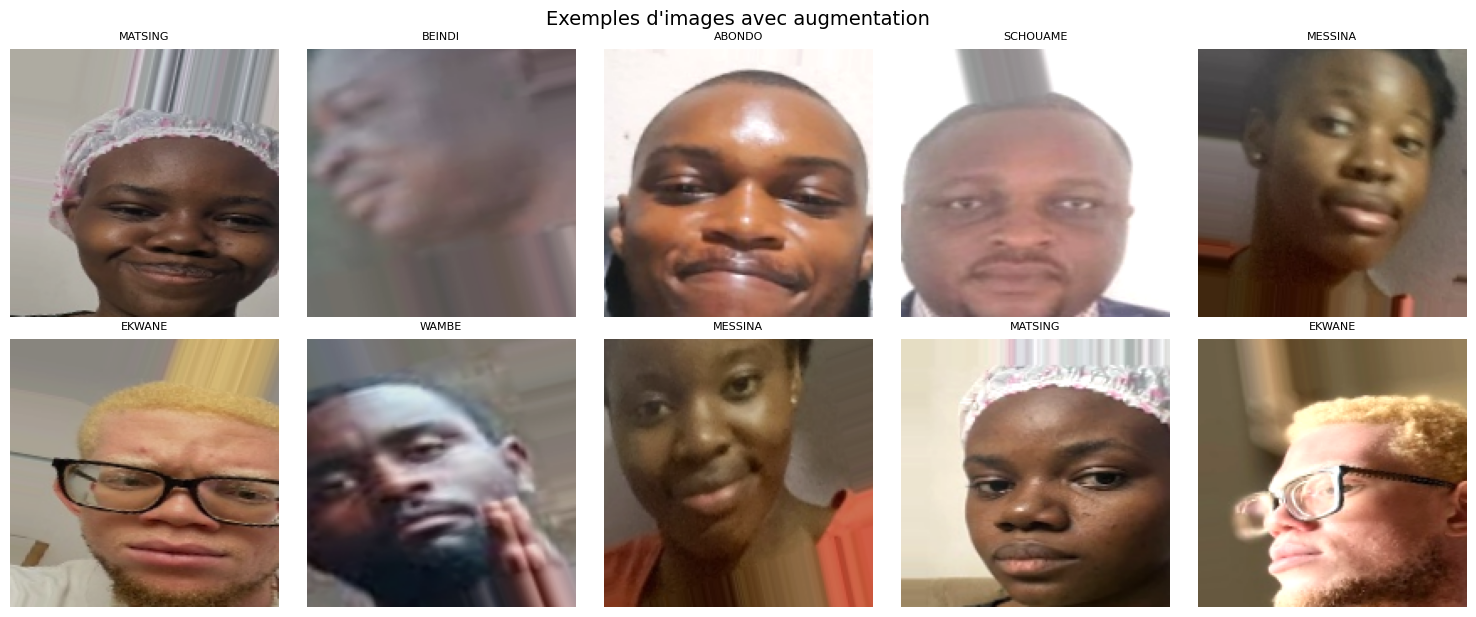

In [21]:
# Visualiser quelques images augmentées
sample_batch = next(train_generator)
images_batch = sample_batch[0]
labels_batch = sample_batch[1]

fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.ravel()

class_names = list(train_generator.class_indices.keys())

for i in range(10):
    axes[i].imshow(images_batch[i])
    label_idx = np.argmax(labels_batch[i])
    axes[i].set_title(f"{class_names[label_idx]}", fontsize=8)
    axes[i].axis('off')

plt.tight_layout()
plt.suptitle('Exemples d\'images avec augmentation', y=1.02, fontsize=14)
plt.show()

## 8. Construction du modèle

Utilisation de MobileNetV2 avec Transfer Learning.

In [22]:
def create_model(num_classes, input_shape=(160, 160, 3)):
    """
    Crée un modèle de reconnaissance faciale basé sur MobileNetV2
    
    Args:
        num_classes: Nombre d'étudiants à reconnaître
        input_shape: Taille des images d'entrée
    
    Returns:
        model: Modèle Keras
        base_model: Modèle de base (pour fine-tuning ultérieur)
    """
    # Charger MobileNetV2 pré-entraîné (sans la couche de classification)
    base_model = MobileNetV2(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )
    
    # Geler les couches de base (pour commencer)
    base_model.trainable = False
    
    # Ajouter les couches personnalisées
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    
    # Créer le modèle complet
    model = Model(inputs=base_model.input, outputs=predictions)
    
    return model, base_model

# Créer le modèle
model, base_model = create_model(num_classes, input_shape=(*IMG_SIZE, 3))

# Afficher le résumé
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 160, 160,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 80, 80,    │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 80, 80,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 80, 80,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 80, 80,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 80, 80,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 80, 80,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 81, 81,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 40, 40,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 40, 40,    │      2,304 │ block_1_depthwis

 Total params: 2,621,267 (10.00 MB)

 Trainable params: 363,283 (1.39 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [23]:
# Compiler le modèle
model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE_PHASE1),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("Modèle compilé!")
print(f"\nNombre total de paramètres: {model.count_params():,}")
print(f"Nombre de paramètres entraînables: {sum([tf.size(w).numpy() for w in model.trainable_weights]):,}")
print(f"Nombre de paramètres non-entraînables: {sum([tf.size(w).numpy() for w in model.non_trainable_weights]):,}")

Modèle compilé!

Nombre total de paramètres: 2,621,267
Nombre de paramètres entraînables: 363,283
Nombre de paramètres non-entraînables: 2,257,984


## 9. Entraînement du modèle - Phase 1

Entraînement avec les couches de base gelées.

In [24]:
# Définir les callbacks
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    ModelCheckpoint(
        os.path.join(MODELS_DIR, 'best_model_phase1.h5'),
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    )
]

print("Callbacks configurés!")

Callbacks configurés!


In [25]:
# Entraînement Phase 1
print("=" * 50)
print("PHASE 1: Entraînement avec couches de base gelées")
print("=" * 50)

history_phase1 = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS_PHASE1,
    callbacks=callbacks,
    verbose=1
)

print("\nPhase 1 terminée!")

PHASE 1: Entraînement avec couches de base gelées


/home/yvan-ngouana/env/monenvironnement/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 958ms/step - accuracy: 0.0662 - loss: 3.4272
Epoch 1: val_accuracy improved from -inf to 0.25000, saving model to models/best_model_phase1.h5


8/8 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.0676 - loss: 3.4133 - val_accuracy: 0.2500 - val_loss: 2.6989 - learning_rate: 0.0010
Epoch 2/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1110 - loss: 2.9312
Epoch 2: val_accuracy improved from 0.25000 to 0.40385, saving model to models/best_model_phase1.h5


8/8 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.1102 - loss: 2.9305 - val_accuracy: 0.4038 - val_loss: 2.5333 - learning_rate: 0.0010
Epoch 3/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2109 - loss: 2.6238
Epoch 3: val_accuracy improved from 0.40385 to 0.48077, saving model to models/best_model_phase1.h5


8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.2114 - loss: 2.6219 - val_accuracy: 0.4808 - val_loss: 2.3601 - learning_rate: 0.0010
Epoch 4/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3080 - loss: 2.5391
Epoch 4: val_accuracy improved from 0.48077 to 0.55769, saving model to models/best_model_phase1.h5


8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.3065 - loss: 2.5363 - val_accuracy: 0.5577 - val_loss: 2.1957 - learning_rate: 0.0010
Epoch 5/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2715 - loss: 2.3295
Epoch 5: val_accuracy did not improve from 0.55769
8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.2759 - loss: 2.3239 - val_accuracy: 0.5192 - val_loss: 2.0156 - learning_rate: 0.0010
Epoch 6/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3339 - loss: 2.2100
Epoch 6: val_accuracy improved from 0.55769 to 0.57692, saving model to models/best_model_phase1.h5


8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.3350 - loss: 2.2141 - val_accuracy: 0.5769 - val_loss: 1.8771 - learning_rate: 0.0010
Epoch 7/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3554 - loss: 2.1695
Epoch 7: val_accuracy did not improve from 0.57692
8/8 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.3588 - loss: 2.1552 - val_accuracy: 0.5000 - val_loss: 1.7833 - learning_rate: 0.0010
Epoch 8/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 948ms/step - accuracy: 0.3855 - loss: 2.0749
Epoch 8: val_accuracy did not improve from 0.57692
8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.3911 - loss: 2.0610 - val_accuracy: 0.5192 - val_loss: 1.6535 - learning_rate: 0.0010
Epoch 9/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 948ms/step - accuracy: 0.4580 - loss: 1.7992
Epoch 9: val_accuracy did not improve from 0.57692
8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.4624 - loss: 1.7914 - val_accuracy: 0.5769 - val_loss: 1.5324 - learning_rate: 0.0010
Epoch 10/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 945ms/step

8/8 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.4672 - loss: 1.5875 - val_accuracy: 0.5962 - val_loss: 1.4578 - learning_rate: 0.0010
Epoch 12/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 938ms/step - accuracy: 0.5737 - loss: 1.3730
Epoch 12: val_accuracy improved from 0.59615 to 0.61538, saving model to models/best_model_phase1.h5


8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.5736 - loss: 1.3801 - val_accuracy: 0.6154 - val_loss: 1.3617 - learning_rate: 0.0010
Epoch 13/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4675 - loss: 1.5799
Epoch 13: val_accuracy did not improve from 0.61538
8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.4722 - loss: 1.5676 - val_accuracy: 0.5962 - val_loss: 1.3066 - learning_rate: 0.0010
Epoch 14/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 949ms/step - accuracy: 0.5622 - loss: 1.3746
Epoch 14: val_accuracy did not improve from 0.61538
8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.5587 - loss: 1.3836 - val_accuracy: 0.6154 - val_loss: 1.2767 - learning_rate: 0.0010
Epoch 15/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 961ms/step - accuracy: 0.5731 - loss: 1.4524
Epoch 15: val_accuracy did not improve from 0.61538
8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.5744 - loss: 1.4437 - val_accuracy: 0.6154 - val_loss: 1.2220 - learning_rate: 0.0010
Epoch 16/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 971m

8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.5715 - loss: 1.3009 - val_accuracy: 0.6346 - val_loss: 1.3054 - learning_rate: 0.0010
Epoch 18/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 949ms/step - accuracy: 0.6162 - loss: 1.2978
Epoch 18: val_accuracy improved from 0.63462 to 0.69231, saving model to models/best_model_phase1.h5


8/8 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.6192 - loss: 1.2839 - val_accuracy: 0.6923 - val_loss: 1.1442 - learning_rate: 0.0010
Epoch 19/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 958ms/step - accuracy: 0.6650 - loss: 1.0619
Epoch 19: val_accuracy did not improve from 0.69231
8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.6603 - loss: 1.0705 - val_accuracy: 0.6731 - val_loss: 1.0782 - learning_rate: 0.0010
Epoch 20/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 960ms/step - accuracy: 0.6636 - loss: 1.0330
Epoch 20: val_accuracy did not improve from 0.69231
8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.6664 - loss: 1.0261 - val_accuracy: 0.6346 - val_loss: 1.2306 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 19.

Phase 1 terminée!


## 10. Entraînement du modèle - Phase 2 (Fine-tuning)

Dégel des couches de base pour le fine-tuning.

In [26]:
# Dégeler les couches de base
base_model.trainable = True

print(f"Nombre de couches dans le modèle de base: {len(base_model.layers)}")

# Optionnel: Geler les premières couches et dégeler uniquement les dernières
# for layer in base_model.layers[:100]:
#     layer.trainable = False

# Recompiler avec un learning rate plus faible
model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE_PHASE2),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print(f"\nNombre de paramètres entraînables après dégel: {sum([tf.size(w).numpy() for w in model.trainable_weights]):,}")

Nombre de couches dans le modèle de base: 154

Nombre de paramètres entraînables après dégel: 2,587,155


In [27]:
# Mettre à jour les callbacks pour la phase 2
callbacks_phase2 = [
    EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    ModelCheckpoint(
        os.path.join(MODELS_DIR, 'best_model_phase2.h5'),
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-8,
        verbose=1
    )
]

In [28]:
# Entraînement Phase 2
print("=" * 50)
print("PHASE 2: Fine-tuning avec toutes les couches dégelées")
print("=" * 50)

history_phase2 = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS_PHASE2,
    callbacks=callbacks_phase2,
    initial_epoch=len(history_phase1.history['loss']),
    verbose=1
)

print("\nPhase 2 terminée!")

PHASE 2: Fine-tuning avec toutes les couches dégelées
Epoch 21/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.1695 - loss: 2.9911
Epoch 21: val_accuracy improved from -inf to 0.71154, saving model to models/best_model_phase2.h5


8/8 ━━━━━━━━━━━━━━━━━━━━ 138s 6s/step - accuracy: 0.1728 - loss: 2.9784 - val_accuracy: 0.7115 - val_loss: 1.0705 - learning_rate: 1.0000e-04
Epoch 22/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.3719 - loss: 2.1731
Epoch 22: val_accuracy did not improve from 0.71154
8/8 ━━━━━━━━━━━━━━━━━━━━ 34s 4s/step - accuracy: 0.3734 - loss: 2.1610 - val_accuracy: 0.6538 - val_loss: 1.1567 - learning_rate: 1.0000e-04
Epoch 23/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.3846 - loss: 1.8959
Epoch 23: val_accuracy did not improve from 0.71154
8/8 ━━━━━━━━━━━━━━━━━━━━ 33s 4s/step - accuracy: 0.3954 - loss: 1.8798 - val_accuracy: 0.6154 - val_loss: 1.2727 - learning_rate: 1.0000e-04
Epoch 24/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.5264 - loss: 1.5210
Epoch 24: val_accuracy did not improve from 0.71154
8/8 ━━━━━━━━━━━━━━━━━━━━ 33s 4s/step - accuracy: 0.5306 - loss: 1.5093 - val_accuracy: 0.6154 - val_loss: 1.2963 - learning_rate: 1.0000e-04
Epoch 25/30
8/8 ━━━━━━━━━━━━━━━━━

## 11. Visualisation de l'entraînement

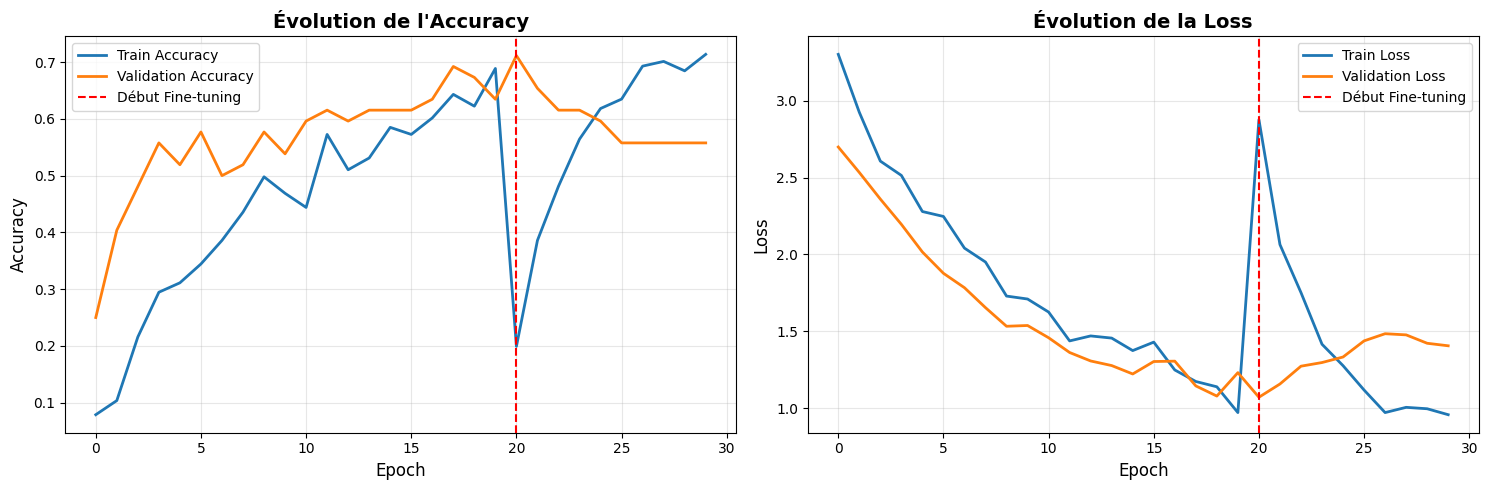

Graphique sauvegardé dans models/training_history.png


In [37]:
# Combiner les historiques
full_history = {}
for key in history_phase1.history.keys():
    full_history[key] = history_phase1.history[key] + history_phase2.history[key]

# Tracer les graphiques
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Accuracy
axes[0].plot(full_history['accuracy'], label='Train Accuracy', linewidth=2)
axes[0].plot(full_history['val_accuracy'], label='Validation Accuracy', linewidth=2)
axes[0].axvline(x=len(history_phase1.history['accuracy']), color='r', linestyle='--', label='Début Fine-tuning')
axes[0].set_title('Évolution de l\'Accuracy', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# Loss
axes[1].plot(full_history['loss'], label='Train Loss', linewidth=2)
axes[1].plot(full_history['val_loss'], label='Validation Loss', linewidth=2)
axes[1].axvline(x=len(history_phase1.history['loss']), color='r', linestyle='--', label='Début Fine-tuning')
axes[1].set_title('Évolution de la Loss', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Loss', fontsize=12)
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(MODELS_DIR, 'training_history.png'), dpi=300, bbox_inches='tight')
plt.show()

print(f"Graphique sauvegardé dans {MODELS_DIR}/training_history.png")

In [38]:
# Afficher les meilleures performances
best_train_acc = max(full_history['accuracy'])
best_val_acc = max(full_history['val_accuracy'])
best_train_loss = min(full_history['loss'])
best_val_loss = min(full_history['val_loss'])

print("=" * 50)
print("MEILLEURES PERFORMANCES PENDANT L'ENTRAÎNEMENT")
print("=" * 50)
print(f"Meilleure Accuracy (Train): {best_train_acc:.4f} ({best_train_acc*100:.2f}%)")
print(f"Meilleure Accuracy (Validation): {best_val_acc:.4f} ({best_val_acc*100:.2f}%)")
print(f"Meilleure Loss (Train): {best_train_loss:.4f}")
print(f"Meilleure Loss (Validation): {best_val_loss:.4f}")
print("=" * 50)

MEILLEURES PERFORMANCES PENDANT L'ENTRAÎNEMENT
Meilleure Accuracy (Train): 0.7137 (71.37%)
Meilleure Accuracy (Validation): 0.7115 (71.15%)
Meilleure Loss (Train): 0.9569
Meilleure Loss (Validation): 1.0705


## 12. Évaluation sur le jeu de test

In [39]:
# Évaluer le modèle sur le test set
print("Évaluation sur le jeu de test...\n")

test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)

print("\n" + "=" * 50)
print("RÉSULTATS SUR LE JEU DE TEST")
print("=" * 50)
print(f"Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"Test Loss: {test_loss:.4f}")
print("=" * 50)

Évaluation sur le jeu de test...



/home/yvan-ngouana/env/monenvironnement/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - accuracy: 0.6054 - loss: 1.1444

RÉSULTATS SUR LE JEU DE TEST
Test Accuracy: 0.5769 (57.69%)
Test Loss: 1.2307


In [40]:
# Prédictions sur le test set
print("Génération des prédictions...\n")

test_generator.reset()
predictions = model.predict(test_generator, verbose=1)
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes

print(f"\nNombre de prédictions: {len(y_pred)}")
print(f"Nombre de vraies étiquettes: {len(y_true)}")

Génération des prédictions...

52/52 ━━━━━━━━━━━━━━━━━━━━ 7s 54ms/step

Nombre de prédictions: 52
Nombre de vraies étiquettes: 52


In [41]:
# Rapport de classification détaillé
class_names = list(test_generator.class_indices.keys())

print("\n" + "=" * 50)
print("RAPPORT DE CLASSIFICATION DÉTAILLÉ")
print("=" * 50)
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))
print("=" * 50)


RAPPORT DE CLASSIFICATION DÉTAILLÉ
              precision    recall  f1-score   support

      ABONDO     0.0000    0.0000    0.0000         2
      BEINDI     0.0000    0.0000    0.0000         2
       DEDIM     0.5000    0.6667    0.5714         3
    DJOKNONE     0.0000    0.0000    0.0000         3
      EKWANE     0.5000    0.6667    0.5714         3
      EWOUDI     0.5000    1.0000    0.6667         3
      KAMATE     1.0000    0.3333    0.5000         3
    KIYINDOU     0.2500    0.5000    0.3333         2
    KOUMETIO     0.5000    0.6667    0.5714         3
        MAMA     0.0000    0.0000    0.0000         3
     MATSING     1.0000    1.0000    1.0000         3
     MESSINA     1.0000    0.6667    0.8000         3
    MODJARBA     0.7500    1.0000    0.8571         3
     NGOUANA     1.0000    0.3333    0.5000         3
       OBAMA     1.0000    1.0000    1.0000         2
     OTABELA     0.0000    0.0000    0.0000         3
    SCHOUAME     0.4000    1.0000    0.5714  

/home/yvan-ngouana/env/monenvironnement/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/yvan-ngouana/env/monenvironnement/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/yvan-ngouana/env/monenvironnement/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{m

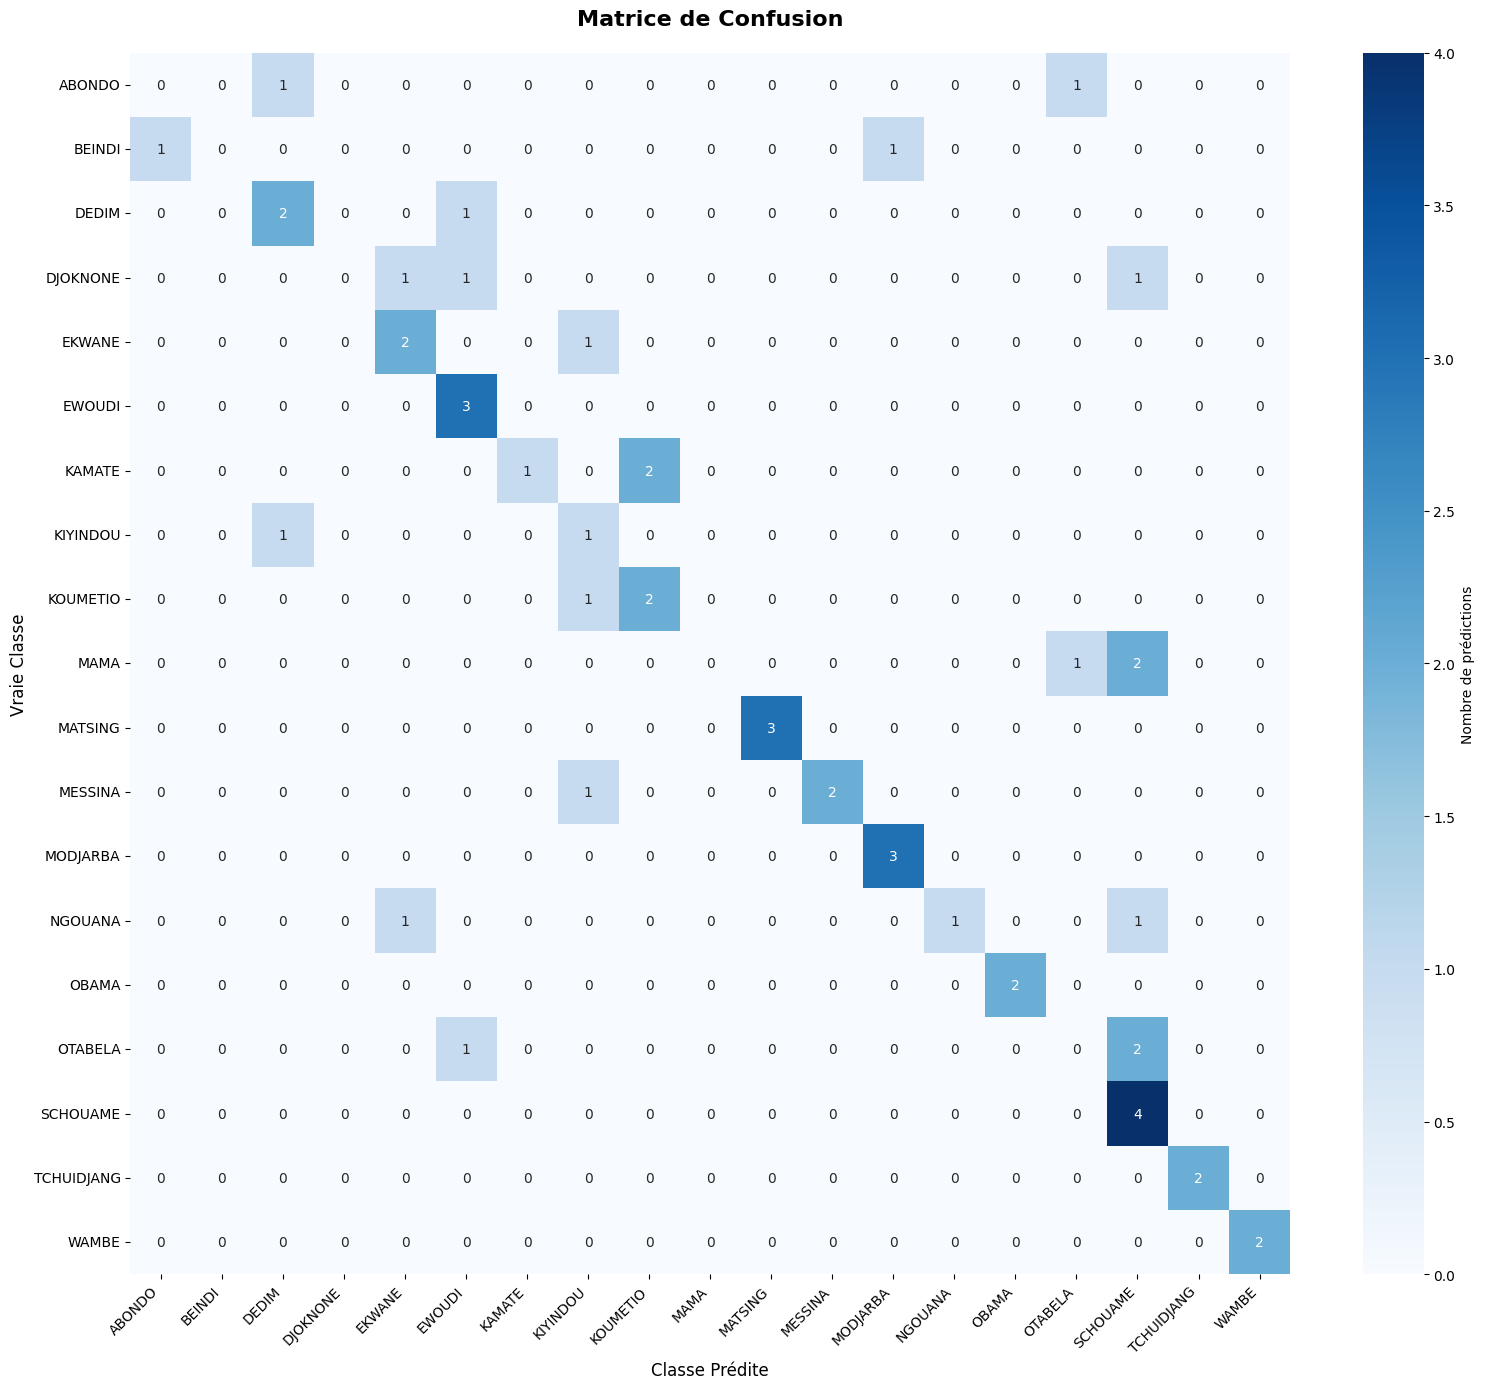

Matrice de confusion sauvegardée dans models/confusion_matrix.png


In [42]:
# Matrice de confusion
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(16, 14))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'label': 'Nombre de prédictions'})
plt.title('Matrice de Confusion', fontsize=16, fontweight='bold', pad=20)
plt.ylabel('Vraie Classe', fontsize=12)
plt.xlabel('Classe Prédite', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig(os.path.join(MODELS_DIR, 'confusion_matrix.png'), dpi=300, bbox_inches='tight')
plt.show()

print(f"Matrice de confusion sauvegardée dans {MODELS_DIR}/confusion_matrix.png")

In [43]:
# Analyser les erreurs de classification
errors = []
for i, (true_label, pred_label) in enumerate(zip(y_true, y_pred)):
    if true_label != pred_label:
        confidence = predictions[i][pred_label] * 100
        errors.append({
            'image_idx': i,
            'true_class': class_names[true_label],
            'predicted_class': class_names[pred_label],
            'confidence': confidence
        })

if errors:
    errors_df = pd.DataFrame(errors)
    print(f"\nNombre d'erreurs: {len(errors)} sur {len(y_true)} ({100*len(errors)/len(y_true):.2f}%)")
    print(f"\nPremières erreurs:")
    print(errors_df.head(10))
else:
    print("\nAucune erreur! Précision parfaite sur le test set!")


Nombre d'erreurs: 22 sur 52 (42.31%)

Premières erreurs:
   image_idx true_class predicted_class  confidence
0          2   DJOKNONE        SCHOUAME   38.572414
1          5     KAMATE        KOUMETIO   47.157391
2          7     KAMATE        KOUMETIO   22.125254
3          9   KIYINDOU           DEDIM   30.758930
4         10       MAMA         OTABELA   22.137751
5         11   KOUMETIO        KIYINDOU   24.542595
6         12    OTABELA          EWOUDI   36.174011
7         15     EKWANE        KIYINDOU   20.722637
8         18   DJOKNONE          EWOUDI   36.288784
9         19     ABONDO           DEDIM   44.785778


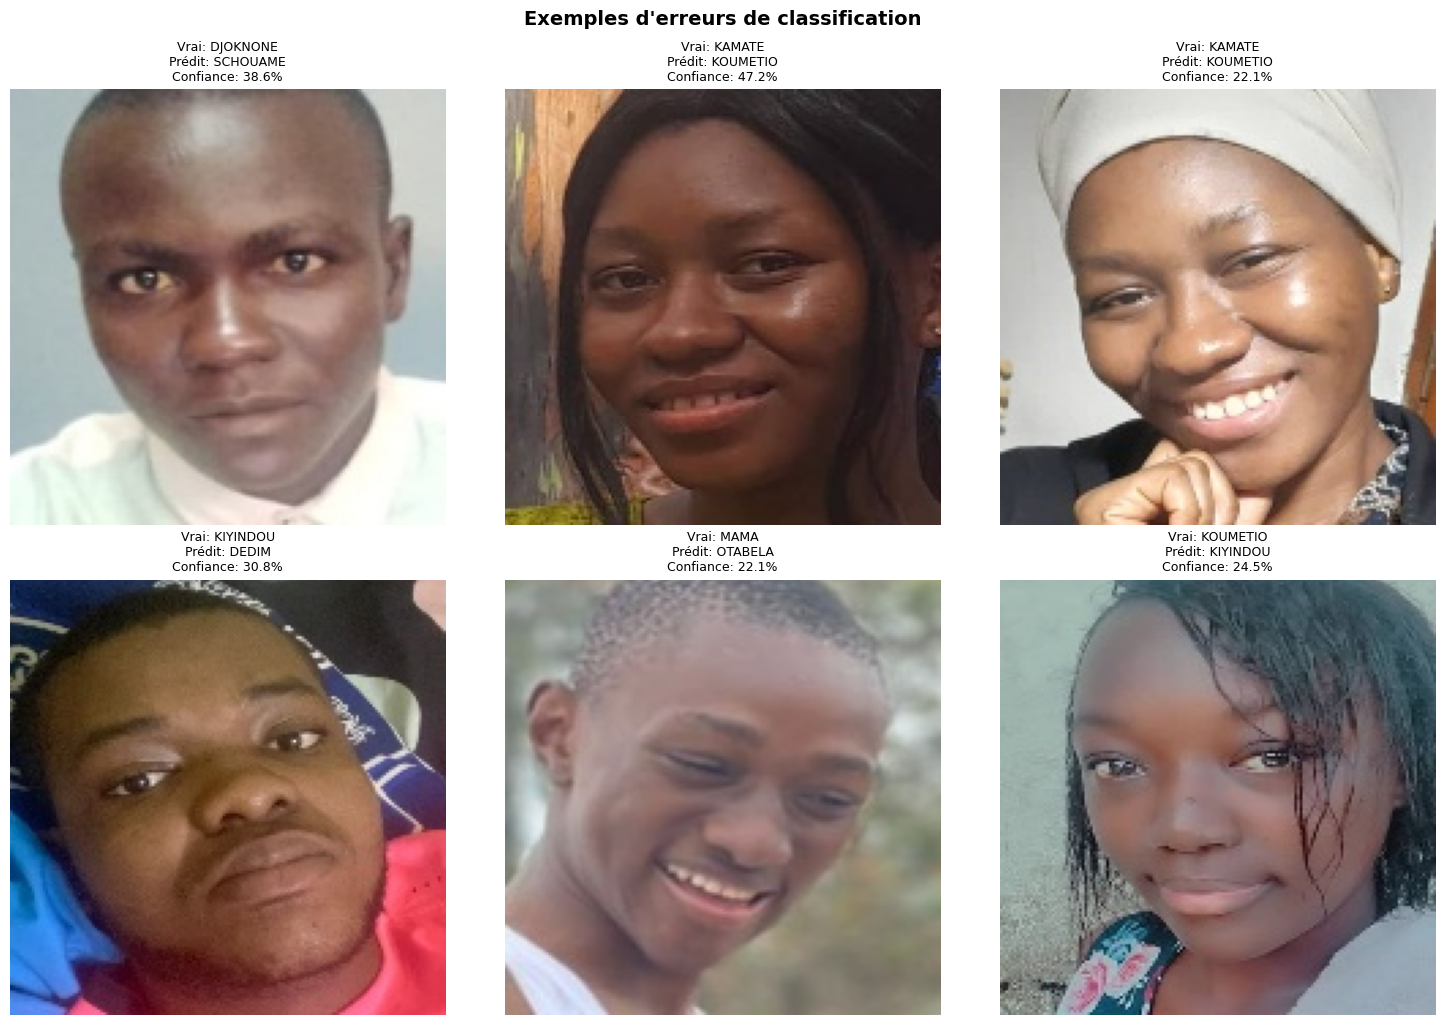

In [44]:
# Visualiser quelques erreurs de classification
if errors and len(errors) >= 6:
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.ravel()
    
    for i, error in enumerate(errors[:6]):
        img_idx = error['image_idx']
        img_path = test_df.iloc[img_idx]['image_path']
        
        img = cv2.imread(img_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        axes[i].imshow(img_rgb)
        axes[i].set_title(
            f"Vrai: {error['true_class']}\n"
            f"Prédit: {error['predicted_class']}\n"
            f"Confiance: {error['confidence']:.1f}%",
            fontsize=9
        )
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.suptitle('Exemples d\'erreurs de classification', y=1.02, fontsize=14, fontweight='bold')
    plt.show()
elif errors:
    print(f"Seulement {len(errors)} erreur(s), pas assez pour une visualisation complète.")

## 13. Sauvegarde du modèle final

In [45]:
# Sauvegarder le modèle final en .h5
final_model_path = os.path.join(MODELS_DIR, 'face_recognition_model.h5')
model.save(final_model_path)
print(f"Modèle sauvegardé dans: {final_model_path}")

# Vérifier la taille du fichier
file_size = os.path.getsize(final_model_path) / (1024 * 1024)  # en MB
print(f"Taille du fichier: {file_size:.2f} MB")

Modèle sauvegardé dans: models/face_recognition_model.h5
Taille du fichier: 30.42 MB


In [46]:
# Sauvegarder la configuration du modèle
config = {
    'num_classes': num_classes,
    'input_shape': list((*IMG_SIZE, 3)),
    'class_names': class_names,
    'test_accuracy': float(test_accuracy),
    'test_loss': float(test_loss),
    'total_images': len(df),
    'train_images': len(train_df),
    'val_images': len(val_df),
    'test_images': len(test_df),
    'batch_size': BATCH_SIZE,
    'epochs_phase1': EPOCHS_PHASE1,
    'epochs_phase2': EPOCHS_PHASE2,
    'best_train_accuracy': float(best_train_acc),
    'best_val_accuracy': float(best_val_acc)
}

config_path = os.path.join(MODELS_DIR, 'model_config.json')
with open(config_path, 'w') as f:
    json.dump(config, f, indent=4)

print(f"Configuration sauvegardée dans: {config_path}")
print("\nContenu de la configuration:")
print(json.dumps(config, indent=2))

Configuration sauvegardée dans: models/model_config.json

Contenu de la configuration:
{
  "num_classes": 19,
  "input_shape": [
    160,
    160,
    3
  ],
  "class_names": [
    "ABONDO",
    "BEINDI",
    "DEDIM",
    "DJOKNONE",
    "EKWANE",
    "EWOUDI",
    "KAMATE",
    "KIYINDOU",
    "KOUMETIO",
    "MAMA",
    "MATSING",
    "MESSINA",
    "MODJARBA",
    "NGOUANA",
    "OBAMA",
    "OTABELA",
    "SCHOUAME",
    "TCHUIDJANG",
    "WAMBE"
  ],
  "test_accuracy": 0.5769230723381042,
  "test_loss": 1.23069429397583,
  "total_images": 345,
  "train_images": 241,
  "val_images": 52,
  "test_images": 52,
  "batch_size": 32,
  "epochs_phase1": 20,
  "epochs_phase2": 30,
  "best_train_accuracy": 0.7136929631233215,
  "best_val_accuracy": 0.7115384340286255
}


In [47]:
# Résumé des fichiers sauvegardés
print("\n" + "=" * 50)
print("FICHIERS SAUVEGARDÉS")
print("=" * 50)
print(f"1. Modèle final: {final_model_path}")
print(f"2. Label encoder: {os.path.join(MODELS_DIR, 'label_encoder.pkl')}")
print(f"3. Configuration: {config_path}")
print(f"4. Graphique d'entraînement: {os.path.join(MODELS_DIR, 'training_history.png')}")
print(f"5. Matrice de confusion: {os.path.join(MODELS_DIR, 'confusion_matrix.png')}")
print(f"6. Dataset train: train.csv")
print(f"7. Dataset validation: val.csv")
print(f"8. Dataset test: test.csv")
print("=" * 50)


FICHIERS SAUVEGARDÉS
1. Modèle final: models/face_recognition_model.h5
2. Label encoder: models/label_encoder.pkl
3. Configuration: models/model_config.json
4. Graphique d'entraînement: models/training_history.png
5. Matrice de confusion: models/confusion_matrix.png
6. Dataset train: train.csv
7. Dataset validation: val.csv
8. Dataset test: test.csv


## 14. Test du modèle chargé

Vérifier que le modèle peut être chargé et utilisé correctement.

In [48]:
# Charger le modèle sauvegardé
loaded_model = load_model(final_model_path)
print("Modèle chargé avec succès!")

# Charger le label encoder
with open(os.path.join(MODELS_DIR, 'label_encoder.pkl'), 'rb') as f:
    loaded_label_encoder = pickle.load(f)
print("Label encoder chargé avec succès!")

# Charger la configuration
with open(config_path, 'r') as f:
    loaded_config = json.load(f)
print("Configuration chargée avec succès!")

print(f"\nNombre de classes dans le modèle chargé: {loaded_config['num_classes']}")

Modèle chargé avec succès!
Label encoder chargé avec succès!
Configuration chargée avec succès!

Nombre de classes dans le modèle chargé: 19


In [49]:
# Fonction de prédiction
def predict_face(model, image_path, label_encoder, top_k=3):
    """
    Prédit l'identité d'une personne sur une image
    
    Args:
        model: Modèle entraîné
        image_path: Chemin vers l'image
        label_encoder: LabelEncoder pour décoder les labels
        top_k: Nombre de prédictions à retourner
    
    Returns:
        Liste des top-k prédictions avec probabilités
    """
    # Charger et pré-traiter l'image
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img_rgb, IMG_SIZE)
    img_normalized = img_resized / 255.0
    img_batch = np.expand_dims(img_normalized, axis=0)
    
    # Prédire
    predictions = model.predict(img_batch, verbose=0)[0]
    
    # Obtenir les top-k prédictions
    top_indices = np.argsort(predictions)[-top_k:][::-1]
    
    results = []
    for idx in top_indices:
        student_name = label_encoder.inverse_transform([idx])[0]
        confidence = predictions[idx] * 100
        results.append({
            'name': student_name,
            'confidence': confidence
        })
    
    return results, img_rgb

print("Fonction de prédiction définie!")

Fonction de prédiction définie!


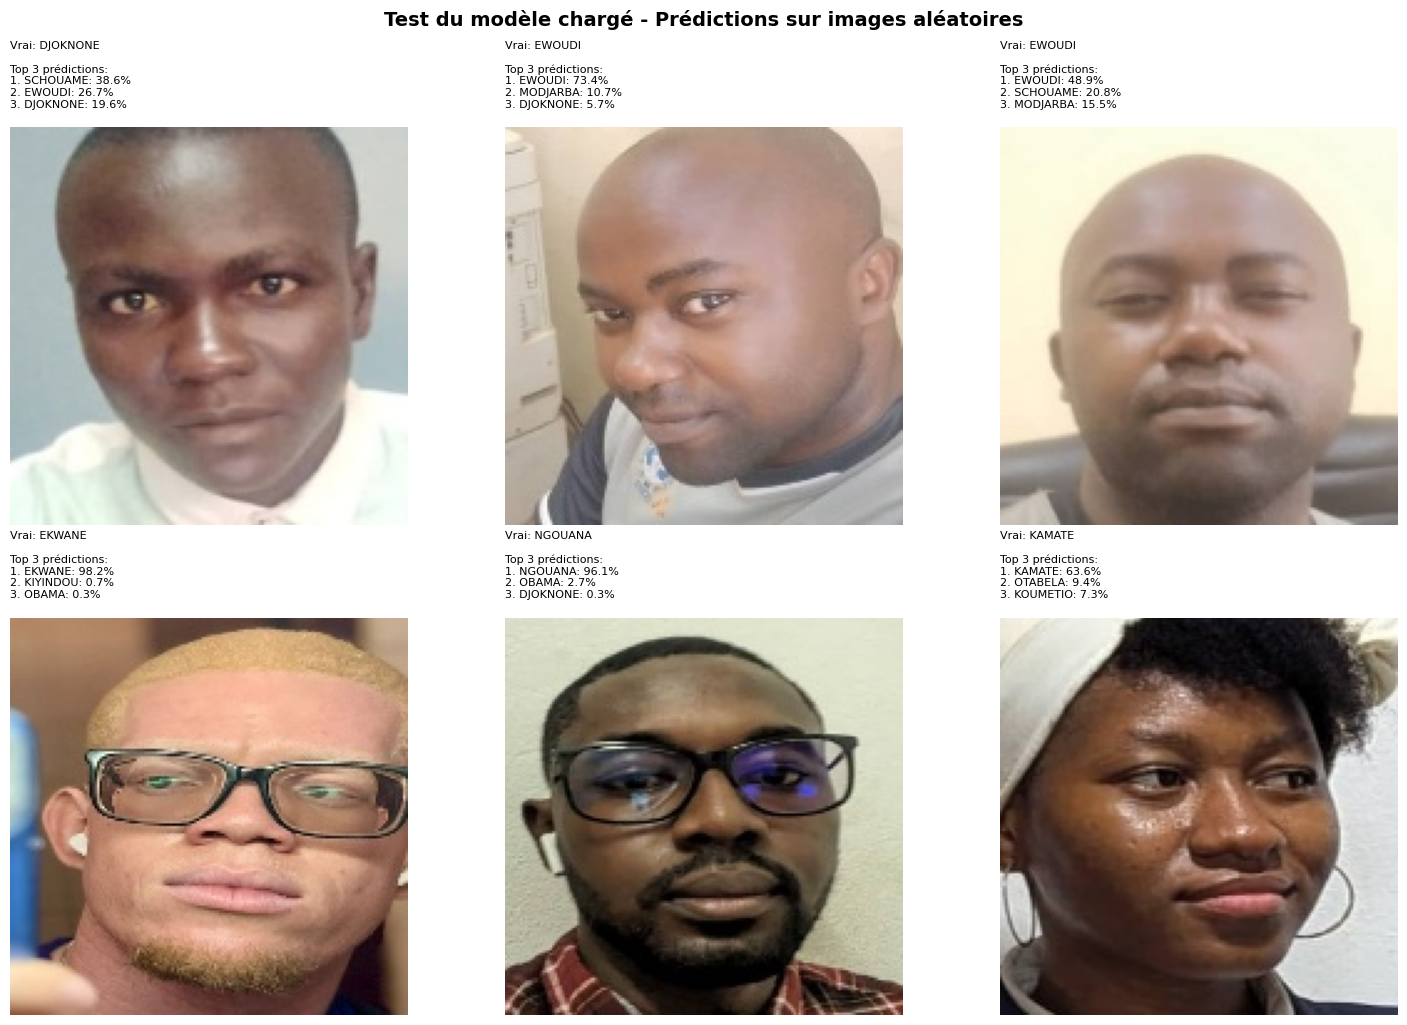

In [50]:
# Tester sur quelques images du test set
test_samples = test_df.sample(6).reset_index(drop=True)

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

for i, row in test_samples.iterrows():
    img_path = row['image_path']
    true_name = row['student_name']
    
    # Prédire
    predictions, img = predict_face(loaded_model, img_path, loaded_label_encoder, top_k=3)
    
    # Afficher
    axes[i].imshow(img)
    
    pred_text = f"Vrai: {true_name}\n\nTop 3 prédictions:\n"
    for j, pred in enumerate(predictions, 1):
        pred_text += f"{j}. {pred['name']}: {pred['confidence']:.1f}%\n"
    
    axes[i].set_title(pred_text, fontsize=8, ha='left', loc='left')
    axes[i].axis('off')

plt.tight_layout()
plt.suptitle('Test du modèle chargé - Prédictions sur images aléatoires', y=1.02, fontsize=14, fontweight='bold')
plt.show()

## 15. Statistiques finales et conclusion

In [51]:
print("\n" + "=" * 70)
print(" " * 15 + "RÉSUMÉ FINAL DU PROJET")
print("=" * 70)

print("\n📊 DONNÉES:")
print(f"  - Nombre total d'images: {len(df)}")
print(f"  - Nombre d'étudiants: {num_classes}")
print(f"  - Images d'entraînement: {len(train_df)} ({100*len(train_df)/len(df):.1f}%)")
print(f"  - Images de validation: {len(val_df)} ({100*len(val_df)/len(df):.1f}%)")
print(f"  - Images de test: {len(test_df)} ({100*len(test_df)/len(df):.1f}%)")

print("\n🏗️ MODÈLE:")
print(f"  - Architecture: MobileNetV2 + Transfer Learning")
print(f"  - Taille des images: {IMG_SIZE[0]}x{IMG_SIZE[1]}")
print(f"  - Nombre de paramètres: {model.count_params():,}")
print(f"  - Taille du fichier .h5: {file_size:.2f} MB")

print("\n📈 PERFORMANCES:")
print(f"  - Accuracy (Train): {best_train_acc*100:.2f}%")
print(f"  - Accuracy (Validation): {best_val_acc*100:.2f}%")
print(f"  - Accuracy (Test): {test_accuracy*100:.2f}%")
print(f"  - Loss (Test): {test_loss:.4f}")

print("\n⚙️ ENTRAÎNEMENT:")
print(f"  - Epochs Phase 1: {EPOCHS_PHASE1}")
print(f"  - Epochs Phase 2: {EPOCHS_PHASE2}")
print(f"  - Batch size: {BATCH_SIZE}")
print(f"  - Augmentation de données: Oui")

print("\n📁 FICHIERS GÉNÉRÉS:")
print(f"  - face_recognition_model.h5")
print(f"  - label_encoder.pkl")
print(f"  - model_config.json")
print(f"  - training_history.png")
print(f"  - confusion_matrix.png")

print("\n" + "=" * 70)
print(" " * 20 + "✅ PROJET TERMINÉ AVEC SUCCÈS!")
print("=" * 70)



               RÉSUMÉ FINAL DU PROJET

📊 DONNÉES:
  - Nombre total d'images: 345
  - Nombre d'étudiants: 19
  - Images d'entraînement: 241 (69.9%)
  - Images de validation: 52 (15.1%)
  - Images de test: 52 (15.1%)

🏗️ MODÈLE:
  - Architecture: MobileNetV2 + Transfer Learning
  - Taille des images: 160x160
  - Nombre de paramètres: 2,621,267
  - Taille du fichier .h5: 30.42 MB

📈 PERFORMANCES:
  - Accuracy (Train): 71.37%
  - Accuracy (Validation): 71.15%
  - Accuracy (Test): 57.69%
  - Loss (Test): 1.2307

⚙️ ENTRAÎNEMENT:
  - Epochs Phase 1: 20
  - Epochs Phase 2: 30
  - Batch size: 32
  - Augmentation de données: Oui

📁 FICHIERS GÉNÉRÉS:
  - face_recognition_model.h5
  - label_encoder.pkl
  - model_config.json
  - training_history.png
  - confusion_matrix.png

                    ✅ PROJET TERMINÉ AVEC SUCCÈS!
